# Comparison: Multivariate Logistic Regression

# Load Data

In [1]:
# only use about 100 samples of each class:
SAMPLE_COUNT_THRESHOLD=100
from sbr.preprocessing import gtex
X, y, class_names, label_df = gtex.dataset_setup(sample_count_threshold = SAMPLE_COUNT_THRESHOLD,
                                          drop_classes_list = ['Bone Marrow', 'Fallopian Tube', 'Cervix Uteri', 'Bladder','Skin'])

Drop under-represented classes with less than 100 samples:
dropped Kidney
dropped Cervix Uteri
dropped Fallopian Tube
dropped Bladder
Counts per class:
(total number of samples, total number of genes) = 
(17244, 18966)
[ 0] Adipose Tissue	1204 samples
[ 1] Muscle      	 803 samples
[ 2] Blood Vessel	1335 samples
[ 3] Heart       	 861 samples
[ 4] Uterus      	 142 samples
[ 5] Vagina      	 156 samples
[ 6] Breast      	 459 samples
[ 7] Skin        	1809 samples
[ 8] Salivary Gland	 162 samples
[ 9] Brain       	2642 samples
[10] Adrenal Gland	 258 samples
[11] Thyroid     	 653 samples
[12] Lung        	 578 samples
[13] Spleen      	 241 samples
[14] Pancreas    	 328 samples
[15] Esophagus   	1445 samples
[16] Stomach     	 359 samples
[17] Colon       	 779 samples
[18] Small Intestine	 187 samples
[19] Prostate    	 245 samples
[20] Testis      	 361 samples
[21] Nerve       	 619 samples
[22] Blood       	 929 samples
[23] Pituitary   	 283 samples
[24] Ovary       	 180 sample

2022-07-23 18:37:08.263211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-23 18:37:08.294519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-23 18:37:08.295203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-23 18:37:08.295898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild Tenso

# Split the data

In [3]:
from sbr.preprocessing.dataset import multicategorical_split,  trim_list_size_to_batch_size_factor
batch_size=32
x_train, y_train, x_validation, y_validation, x_test, y_test = multicategorical_split(X, y,
                                                                                      sample_count_threshold = SAMPLE_COUNT_THRESHOLD,
                                                                                      test_fraction = 0.1,
                                                                                      validation_fraction = 0.1,
                                                                                      verbose=True,
                                                                                      batch_size=batch_size,
                                                                                      seed=42)
#[x_train, y_train, x_validation, y_validation, x_test,y_test] = trim_list_size_to_batch_size_factor(batch_size, [x_train, y_train,
#                                                                                                   x_validation,
#                                                                                                   y_validation,
#                                                                                                   x_test, y_test])
#


Total remaining samples after subsampling= 2600


'\n[x_train, y_train, x_validation, y_validation, x_test,y_test] = trim_list_size_to_batch_size_factor(batch_size, [x_train, y_train,\n                                                                                                   x_validation,\n                                                                                                   y_validation,\n                                                                                                   x_test, y_test])\n'

# Multivariate logistic regression

Multinomial logistic regression extends binomial logistic regression beyond binary classification to solve multi-class prediction problems. Like binomial logistic regression, multinomial logistic regression evaluates the probability of categorical membership using maximum likelihood estimation. For a tissue classifier, it would be beneficial to allow all the data to inform the classification, hence the desire for a multinomial solution. Step one considers multi-logistic regression, an approach for finding solutions with more than two possible outcome valuse which are not ordered. The data to be analyzed, gene expression counts, are comprised of nonlinear covariates, so categorical cross-entropy (a.k.a. "log loss") is better than mean squared error (MSE) for the loss function, with MSE being more common in analyzing linear models. Gene expression data is very noisy, so logistic regression may seem a good approach for its robustness to noisy data.

https://builtin.com/data-science/guide-logistic-regression-tensorflow-20

In [4]:
# import modules
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import numpy as np

x_train.shape, x_test.shape, y_train.shape, y_test.shape , len(np.argmax(y_train,axis=1))

((2080, 18963), (260, 18963), (2080, 26), (260, 26), 2080)

In [5]:
# set up hyperparameters and dataset parameters
num_classes = y_train.shape[1]
num_features = x_train.shape[1]
x_train = tf.cast(x_train, dtype=tf.float32)
y_train = tf.cast(np.argmax(y_train, axis=1), dtype=tf.int32)

x_test = tf.cast(x_test, dtype=tf.float32)
y_test = tf.cast(np.argmax(y_test, axis=1), dtype=tf.int32)


In [6]:
# Logistic regression (Wx + b).
def logistic_regression(x):
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# define optimizers and accuracy metrics

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of the highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)

    # Compute gradients.
    gradients = g.gradient(loss, [W, b])

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, [W, b]))
    

2022-07-23 18:43:16.293727: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Test Accuracy: 0.953846
Test Accuracy: 0.926923
Test Accuracy: 0.950000
Test Accuracy: 0.950000
Test Accuracy: 0.950000


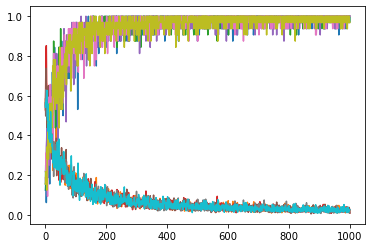

In [7]:
acc_list = []
for i in range(5):
    batch_size=32
    import numpy as np

    import sklearn
    from sklearn.utils.class_weight import compute_class_weight
    y_integers = y_train
    class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', 
                                                                    classes=np.unique(y_integers), 
                                                                    y=y_integers.numpy())

    # shuffling and batch the data
    train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
    train_data=train_data.repeat().shuffle(100).batch(batch_size).prefetch(1)

    # initialize weights and biases
    # Weight of shape [18963, 27], the features, and a total number of classes.
    W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
    # Bias of shape [27], the total number of classes.
    b = tf.Variable(tf.zeros([num_classes]), name="bias")

    # define the logistic regression cost


    # Optimization process and updating weights and biases

    # Stochastic gradient descent optimizer.
    learning_rate = 0.001
    optimizer = tf.optimizers.SGD(learning_rate)

    # Training parameters.
    training_steps = 1000
    display_step = 1

    # training loop

    history={"accuracy":[], "loss":[]}
    # Run training for the given number of steps.
    for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # Run the optimization to update W and b values.
        batch_x = batch_x
        batch_y = batch_y

        run_optimization(batch_x, batch_y)
        if step % display_step == 0:
            pred = logistic_regression(batch_x)
            loss = cross_entropy(pred, batch_y)
            acc = accuracy(pred, batch_y)
            history["accuracy"].append(acc)
            history["loss"].append(loss)
            #print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

    import matplotlib.pyplot as plt
    plt.plot(history["accuracy"])
    plt.plot(np.array(history["loss"])/160.);

    y_pred = logistic_regression(x_test)
    acc = accuracy(y_pred, y_test)
    print("Test Accuracy: %f" % acc)
    acc_list.append(acc)
    


# Accuracy
Average accuracy for our multinomial linear regression is about 0.95, vs the neural network, which achieved an accuracy of 0.98 in the training pipeline.

0.9461538 0.0097300755 [0.95384616, 0.9269231, 0.95, 0.95, 0.95]


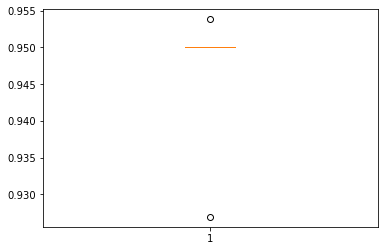

In [8]:
import matplotlib.pyplot as plt
acc_np_list = list(map(lambda x: x.numpy() ,acc_list))
print(np.mean(acc_np_list), np.std(acc_np_list), acc_np_list)
plt.boxplot(acc_np_list);

In [9]:
y_pred_class=np.argmax(pred,axis=1)

print(f"{'Tissue':12} Fraction of predictions")
for i in range(26):
    print(f"{class_names[i]:15} {len(y_pred_class[y_pred_class==i])/len(y_pred_class):2.4}")

Tissue       Fraction of predictions
Adipose Tissue  0.125
Adrenal Gland   0.0
Blood           0.0625
Blood Vessel    0.09375
Brain           0.125
Breast          0.03125
Colon           0.125
Esophagus       0.03125
Heart           0.09375
Liver           0.0
Lung            0.03125
Muscle          0.0
Nerve           0.0
Ovary           0.03125
Pancreas        0.0
Pituitary       0.03125
Prostate        0.0
Salivary Gland  0.0
Skin            0.125
Small Intestine 0.0
Spleen          0.0
Stomach         0.0
Testis          0.03125
Thyroid         0.0625
Uterus          0.0
Vagina          0.0
